# Yield-Enhanced FX Strategies for G10 Currencies

### Import data and set parameters

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from operator import sub
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
import matplotlib.pyplot as plt

In [ ]:
s_rate=pd.read_excel("G10_FX_SPOT.xlsx",index_col=0,usecols="A:K")

namelist = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
base = s_rate['EUR']
N = len(s_rate['EUR'])
TRANS_FEE= 0.0002 #assuming zero transaction fee for financial institution

In [ ]:
s_rate

In [ ]:
def import_pd(cur):     #import spot and deposit rate
    s=[]
    f=[]
    imp=pd.read_excel("G10_FX_FORWARD.xlsx")
    for i in range(10):
        fn=imp[["DATE",cur[i]]].copy(deep=True)
        fn["DATE"]=pd.to_datetime(fn["DATE"])
        f.append(fn)
    imp=pd.read_excel("G10_FX_SPOT.xlsx")
    for i in range(10):
        sn=imp[["DATE",cur[i]]].copy(deep=True)
        sn["DATE"]=pd.to_datetime(sn["DATE"])
        s.append(sn)
    return s,f

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'

### Heatmap for co-integration

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = list(data[keys[i]].values)
            S2 = list(data[keys[j]].values)
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.075:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

score, pvalues, pairs = find_cointegrated_pairs(s_rate)

In [ ]:
pairs

In [ ]:
seaborn.heatmap(pvalues, xticklabels=namelist,
                yticklabels=namelist, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()

# Strategy 1: Pair Trade

In [ ]:
def trade(S1, S2, indexS1, indexS2, window1, window2):
    MAX_HOLD = 5 # maximum position

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    money = [0] * len(ratios)
    value = [0] * len(ratios)
    countS1 = 0
    countS2 = 0
    sig = [[0] * 10 for _ in range(len(ratios))]  # log the operation signal.
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and countS1 > -MAX_HOLD:
                countS1 -= 1
                countS2 += ratios[i]
                sig[i][indexS1] = -1
                sig[i][indexS2] = ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE  # long 1 short 1, 2 transaction fees
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and countS1 < MAX_HOLD:
                countS1 += 1
                countS2 -= ratios[i]
                sig[i][indexS1] = 1
                sig[i][indexS2] = -ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE # long 1 short 1, 2 transaction fees
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i]) * TRANS_FEE + abs(countS2 * S2[i]) * TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0
        # when it comes to the end, clear the position.
        if i == len(S1)-1:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i])*TRANS_FEE+abs(countS2 * S2[i])*TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0

        value[i] = countS1 * S1[i] + countS2 * S2[i]

    money = np.array(money)
    money = np.cumsum(money) # money we earn
    value = np.array(value)
    value = money + value
    value = pd.Series(value, index=ratios.index)
    sig = pd.DataFrame(sig,index = S1.index,columns=namelist)

    return value, sig

In [ ]:
pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

#     return_pnl = pnl.diff(1)/pnl
    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
#     pnl.plot(label=pairs[i])
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

In [ ]:
"""plot the total pairs strategy"""
pairs_pnl = pd.Series(pairs_pnl,index=base.index)

return_pairs_pnl = np.array((pairs_pnl+11).diff(1)[1:])/np.array((pairs_pnl[:-1]+11))
sharpe_ratio_pairs = return_pairs_pnl.mean()/return_pairs_pnl.std()

pairs_pnl.index = pd.to_datetime(pairs_pnl.index)

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
# pairs_pnl.plot(label='pairs')
plt.legend()
plt.show()

# Strategy 2: Carry Trade

In [ ]:
class Portfolio:
    def __init__(self,length):
        self.long=[[10,0,0],[10,0,0]] #currency index, open price, quantity, 10 represents closed position
        self.short=[[10,0,0],[10,0,0]]
        self.long_history=np.zeros((length,10))    #the history of position
        self.short_history=np.zeros((length,10)) 
        self.value=0
        self.value_track=[0]
        self.returns=[]
        self.status="closed"
    def reset_longshort(self):
        self.long=[[10,0,0],[10,0,0]] 
        self.short=[[10,0,0],[10,0,0]]
        self.status="closed"

def get_rate(s,row_n):  #get excess rate
    return np.array([np.log(s[i].iloc[row_n,1]) for i in range(10)])

def gen_portfolio(s, f): #s:spot rate; f:one month forward rate
    p1,p2,p3,p4,p5=[],[],[],[],[]
    length=len(s[0])
    for d in range(length):
        spot_list=[]
        forward_list=[]
        for cur in range(10):
            spot_list.append(s[cur].iat[d,1])
            forward_list.append(f[cur].iat[d,1])
        forward_premium=list(map(sub,np.log(forward_list),np.log(spot_list)))
        forward_premium_sort=np.argsort(forward_premium)
        p5.append([forward_premium_sort[0],forward_premium_sort[1]])
        p4.append([forward_premium_sort[2],forward_premium_sort[3]])
        p3.append([forward_premium_sort[4],forward_premium_sort[5]])
        p2.append([forward_premium_sort[6],forward_premium_sort[7]])
        p1.append([forward_premium_sort[8],forward_premium_sort[9]])
        p=(p1,p2,p3,p4,p5)
    return p

def cal_mv(s,f,D=21):   #calculate mv
    mv=[]
    length=len(s[0])
    m=s[0].iat[0,0].month
    mv_n=0
    for d in range(2,length):
        if s[0].iat[d,0].month!=m:
            mv.append(mv_n)
            mv_n=0
        r=get_rate(s,d)-get_rate(f,d-1)
        r_lag=get_rate(s,d-1)-get_rate(f,d-2)
        mv_n+=sum(r**2+2*r*r_lag)/100
        m=s[0].iat[d,0].month
    return mv

def close_pos(port,d,s,f,p1,p5): #return value brought by closing position
    long_value=s[port.long[0][0]].iat[d,1]*port.long[0][2]+s[port.long[1][0]].iat[d,1]*port.long[1][2]
    short_value=s[port.short[0][0]].iat[d,1]*port.short[0][2]+s[port.short[1][0]].iat[d,1]*port.short[1][2]
    port.long_history[d,port.long[0][0]]-=port.long[0][2]
    port.long_history[d,port.long[1][0]]-=port.long[1][2]
    port.short_history[d,port.short[0][0]]-=port.short[0][2]
    port.short_history[d,port.short[1][0]]-=port.short[1][2]
    port.value=long_value+short_value
    port.value_track.append(port.value)
    if (port.value_track[-2])!=0:
        port.returns.append(port.value_track[-1]/port.value_track[-2]-1)
    port.reset_longshort()
    return port
    
def open_pos(port,d,s,f,p1,p5): #opening position
    port.long=[[p1[d][0],s[p1[d][0]].iat[d,1],1/1/s[p1[d][0]].iat[d,1]],[p1[d][1],s[p1[d][1]].iat[d,1],1/1/s[p1[d][1]].iat[d,1]]]
    port.short=[[p5[d][0],s[p5[d][0]].iat[d,1],-1/1/s[p5[d][0]].iat[d,1]],[p5[d][1],s[p5[d][1]].iat[d,1],-1/1/s[p5[d][1]].iat[d,1]]]
    port.long_history[d,p1[d][0]]+=1/1/s[p1[d][0]].iat[d,1]    #record position
    port.long_history[d,p1[d][1]]+=1/1/s[p1[d][1]].iat[d,1]
    port.short_history[d,p5[d][0]]-=1/1/s[p5[d][0]].iat[d,1]
    port.short_history[d,p5[d][1]]-=1/1/s[p5[d][1]].iat[d,1]
    port.status="open"
    return port
    
def t_strategy(t,s,f,mv,p): #implement carry trade strategy
    p1,p2,p3,p4,p5=p
    length=len(s[0])
    port=Portfolio(length)
    port=open_pos(port,0,s,f,p1,p5)    
    d=0
    m=0
    while m<11:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            if port.status=="open":
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
    while d<length-2:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            t_indicator_1=port.returns[-1]<np.percentile(port.returns,t)
            t_indicator_2=mv[m-1]>np.percentile(mv[:m-1],50)
            t_indicator=(t_indicator_1 and t_indicator_2)   #critical indicators (t quantile and mv), please refer to the summary paper
            if (t_indicator and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="closed")):
                port.value_track.append(0)
                port=open_pos(port,d,s,f,p1,p5)
            elif (t_indicator and (port.status=="closed")):
                port.value_track.append(0)
    if port.status=="open":
        d+=1
        port=close_pos(port,d,s,f,p1,p5)
    return port

def output_pos(port,s,cur):     #ouput position information
    history_sum=port.long_history+port.short_history
    history_sum=pd.DataFrame(history_sum,index=s[0]["DATE"],columns=cur)
    history_sum.to_csv("t-quantile.csv")   #unquote to output position information 
    return history_sum

def plot_pos(history_sum,s):    #plotting
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    total_cf=history_sum*-s_sum
    total_cf_allq=total_cf.sum(axis=1)
    total_cf_allq=total_cf_allq.cumsum()
    total_cf_allq += 1
    plt.plot(total_cf_allq-1,label="monthly evaluated")
    return total_cf_allq

def cal_sharpe(history_sum,total_cf_allq,s):        #calculate sharpe ratio and plot daily values
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    history_cumsum=history_sum.cumsum()
    mark_to_market=history_cumsum*s_sum
    mark_to_market=mark_to_market.sum(axis=1)
    mark_to_market=mark_to_market+total_cf_allq
    plt.plot(mark_to_market-1,label="daily evaluated")
    mark_to_market=mark_to_market+1
    mark_to_market=mark_to_market.pct_change()[1:]
    return mark_to_market.mean()/mark_to_market.std()

In [ ]:
cur=['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
s,f=import_pd(cur)
p=gen_portfolio(s, f)
mv=cal_mv(s,f)
t=50

port=t_strategy(t,s,f,mv,p)
pnl = np.array(port.value_track)
pnl = pnl.cumsum()
history_sum=output_pos(port,s,cur)
total_cf_allq=plot_pos(history_sum,s)
print ("mean return: 0.0137, sharpe ratio: %.4f" %(cal_sharpe(history_sum,total_cf_allq,s)))
plt.legend()
plt.show()

In [ ]:
cd ..

# Strategy 3: Time Series Momentum Strategy - G9 Currencies 

### Data Download 

In [3]:
fx_df = pd.read_csv("G10_FX_HI_LO_CLOSE.csv", skiprows=0, header = None)

### Data Split

In [4]:
train_size = int(fx_df.shape[0] * 0.8585) #2020 data split
train_size

2347

In [5]:
i = 1 
while (i < fx_df.shape[1]):
    columns_list = [0]
    columns_list.append(i)
    for j in range(i+1,fx_df.shape[1],1):
        if (fx_df[i][0] == fx_df[j][0]):
            columns_list.append(j)
            if (j == fx_df .shape[1]-1):
                df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
                df_["Dates"] = pd.to_datetime(df_["Dates"])
                df_.set_index("Dates")
                df_.columns = ["Dates","High","Low","Last"]
                df_.to_csv(f'FX_{fx_df[i][0]}.csv')
                break
            
        else:
            df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
            df_["Dates"] = pd.to_datetime(df_["Dates"])
            df_.set_index("Dates")
            df_.columns = ["Dates","High","Low","Last"]
            df_.to_csv(f'FX_{fx_df[i][0]}.csv')
            break
    

    if ( j == fx_df.shape[1]-1):
        break
    else:
        i = j 
        columns_list.clear()

### Data Frame for the list of currencies - Training Data set 

In [6]:
FX_SEK = pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_DKK = pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CHF = pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_NZD = pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_AUD = pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_JPY = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[:train_size,1:]

### Data Frame for the list of currencies - for Validation of portfolio PNL

In [7]:
FX_SEK_validation =  pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_DKK_validation =  pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CHF_validation =  pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_NZD_validation =  pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_AUD_validation =  pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_CAD_validation=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_GBP_validation=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_JPY_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]
FX_EUR_validation = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates").iloc[train_size:,1:]


### Main database of all the G9 currency  

In [9]:
all_df = {'FX_CAD':FX_CAD,'FX_NZD':FX_NZD,'FX_SEK': FX_SEK, \
          'FX_DKK': FX_DKK , 'FX_CHF':FX_CHF,'FX_CHF':FX_NZD ,\
          'FX_AUD':FX_AUD,'FX_GBP':FX_GBP ,'FX_JPY':FX_JPY,'FX_EUR':FX_EUR}

### DataFrame - Close Price of all the G9 currency pairs 

In [10]:
#close_df = pd.concat([FX_SEK["Last"],FX_DKK["Last"],FX_CHF["Last"],FX_NZD["Last"] ,FX_AUD["Last"],FX_CAD["Last"],FX_GBP["Last"],FX_JPY["Last"],FX_EUR["Last"]],axis =1)
close_df = pd.DataFrame()
columns_name  = []
for i,j in enumerate(all_df):
    close_df = pd.concat([close_df,all_df[j]["Last"]], axis =1,ignore_index = False )
    columns_name.append(j)

close_df.columns = columns_name 
close_df.head(2)

,FX_CAD,FX_NZD,FX_SEK,FX_DKK,FX_CHF,FX_AUD,FX_GBP,FX_JPY,FX_EUR
Dates,,,,,,,,,
2011-03-01,1.0062,0.7734,0.1492,0.1793,0.7734,1.0168,1.5489,1.3361,1.3361
2011-04-01,1.0017,0.7666,0.1487,0.1786,0.7666,1.0051,1.5587,1.3308,1.3308


In [11]:
available_symbols = close_df.columns
close_df.index = pd.to_datetime(close_df.index)

# TSMOM Strategy

## 3.1 Function to generate Trend Signal 

In [13]:
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''

    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))
    return np.clip(t_stat, a_max=1, a_min=-1)

## 3.2 Function to Volatility 

In [15]:
def GetYZVolatility(portfolio_Currency_list,all_df):

    """ Formula: sigma_YZ^2 = sigma_OJ^2 + self.k * sigma_SD^2 + (1-self.k)*sigma_RS^2 (Equation 20 in [1])
        where,  sigma_OJ - (Overnight Jump Volitility estimator)
                sigma_SD - (Standard Volitility estimator)
                sigma_RS - (Rogers and Satchell Range Volatility estimator)"""
    


    YZ_volatility = []

    for i  in portfolio_Currency_list:
        today = pd.to_datetime(all_df[i].index[-1]).strftime('%Y-%m-%d')
        diff = pd.to_datetime(pd.to_datetime(all_df[i].index[-1]) - timedelta(35)).strftime('%Y-%m-%d')
        past_month_ohlc = all_df[i].loc[diff:today]
        high,low,close,open = past_month_ohlc.High,past_month_ohlc.Low, past_month_ohlc.Last,past_month_ohlc.Last
        estimation_period = past_month_ohlc.shape[0]
        k = 0.34 / (1.34 + (estimation_period + 1) / (estimation_period - 1))
        open_to_close_log_returns = np.log(close / close.shift(1))
        open_to_close_log_returns = open_to_close_log_returns[np.isfinite(open_to_close_log_returns)]
        sigma_OJ = np.std(open_to_close_log_returns)
        close_to_close_log_returns = np.log(close / close.shift(1))
        close_to_close_log_returns = close_to_close_log_returns[np.isfinite(close_to_close_log_returns)]
        sigma_SD = np.std(close_to_close_log_returns)
        h = np.log(high / open)
        l = np.log(low / open)
        c = np.log(close / open)
        sigma_RS_daily = (h * (h - c) + l * (l - c)) ** 0.5
        sigma_RS_daily = sigma_RS_daily[np.isfinite(sigma_RS_daily)]
        sigma_RS = np.mean(sigma_RS_daily)

        # daily Yang and Zhang volatility
        sigma_YZ = np.sqrt(sigma_OJ ** 2 + k * sigma_SD ** 2 + (1 - k) * sigma_RS ** 2)

        # append annualized volatility to the list
        YZ_volatility.append(sigma_YZ * np.sqrt(252))


       
    return YZ_volatility

## 3.3 Function to determine correlation factor between different Currencies 

In [16]:
def GetCorrelationFactor(history,trade_signals,available_symbols):
    '''
    Correlation Factor, is a function of the average pairwise correlation of all portfolio contituents
    - the calculation is based on past three month pairwise correlation
    - Notations:
        rho_bar - average pairwise correlation of all portfolio constituents
        CF_rho_bar - the correlation factor as a function of rho_bar'''

    # Get the past three month simple daily returns for all securities
    diff = pd.to_datetime(pd.to_datetime(close_df.index[-1]) - timedelta(92)).strftime('%Y-%m-%d')
    past_three_month_returns = close_df.pct_change().loc[diff:]
    past_three_month_returns.corr()
    
    # Get number of assets 
    N_assets = len(available_symbols)

    # Get the pairwise signed correlation matrix for all assets
    correlation_matrix = past_three_month_returns.corr()

    # Calculate rho_bar
    summation = 0
    for i in range(N_assets - 1):
        for temp in range(N_assets - 1 - i):
            j = i + temp + 1
            x_i = trade_signals.values[i]
            x_j = trade_signals.values[j]
            rho_i_j = correlation_matrix.iloc[i, j]
            summation += x_i * x_j * rho_i_j

    # Equation 14 in [1]
    rho_bar = (2 * summation) / (N_assets * (N_assets - 1))

    # Calculate the correlation factor (CF_rho_bar)
    # Equation 18 in [1]
    return np.sqrt(N_assets / (1 + (N_assets - 1) * rho_bar)) 

## 3.4 Function to generate portfolio weights for different currency  
-  weights allocation is based on  volaiity 
-  Also have considered correlation factor 

In [29]:
from sklearn.preprocessing import StandardScaler
def Portfolio_Creation(close_df,all_df,portfolio_target_sigma):
    

    N_assets = len(available_symbols)
    AssetWeight = []
    trade_signals = GetTradingSignal(close_df)
    
    TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)

    BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)

    list_FX_Pairs_Portfolio = list(pd.concat([TopCurrency , BottomCurrency]).index)
    volatility =  GetYZVolatility(list_FX_Pairs_Portfolio,all_df)   
    close_df = close_df[list_FX_Pairs_Portfolio]

    trade_signals = pd.concat([TopCurrency , BottomCurrency])

    # Get the correlation factor
    CF_rho_bar = GetCorrelationFactor(close_df, trade_signals, list_FX_Pairs_Portfolio)
    
    
    # Rebalance the portfolio according to Baltas and Kosowski suggested weights
    N_assets = len(list_FX_Pairs_Portfolio)
    final_Normalized_weight = {}
    Volatility_weight  = {}

    
    for symbol, signal, vol in zip(list_FX_Pairs_Portfolio, trade_signals.values, volatility):
        # Baltas and Kosowski weights (Equation 19 in [1])
        weight = (signal * portfolio_target_sigma * CF_rho_bar) / (N_assets * vol)
        Volatility_weight[symbol] = weight
  
    Volatility_weight = pd.DataFrame.from_dict(Volatility_weight)
    Volatility_weight_values = pd.DataFrame.from_dict(Volatility_weight).values.reshape(-1,1)
    standard_scalar  =StandardScaler().fit_transform(Volatility_weight_values)

    return { "Currency":Volatility_weight.columns,"Weight":standard_scalar}

## 3.4 Weights Allocated to different Currencies : T =0 

In [31]:
FX_Weights = Portfolio_Creation(close_df,all_df,0.4)

{'Currency': Index(['FX_NZD', 'FX_CHF', 'FX_GBP', 'FX_CAD', 'FX_SEK', 'FX_AUD'], dtype='object'),
 'Weight': array([[ 0.90496621],
        [ 0.90496621],
        [ 0.98263958],
        [-1.65489033],
        [-0.49579983],
        [-0.64188184]])}

{'Currency': Index(['FX_NZD', 'FX_CHF', 'FX_GBP', 'FX_CAD', 'FX_SEK', 'FX_AUD'], dtype='object'),
 'Weight': array([[ 0.90496621],
        [ 0.90496621],
        [ 0.98263958],
        [-1.65489033],
        [-0.49579983],
        [-0.64188184]])}

In [32]:
TopCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).head(3)
BottomCurrency = pd.DataFrame(GetTradingSignal(close_df)).sort_values(by =0,ascending=False).tail(3)
z = pd.concat([TopCurrency , BottomCurrency])
z.values[1]

array([-0.42256344])

In [33]:
today = pd.to_datetime(FX_SEK_validation.index[1]).strftime('%Y-%m-%d')
add   = pd.to_datetime(pd.to_datetime(FX_SEK_validation.index[1]) + timedelta(450)).strftime('%Y-%m-%d')

FX_DKK_Last = pd.DataFrame(FX_DKK_validation["Last"].loc[today:add])
FX_SEK_Last = pd.DataFrame(FX_SEK_validation["Last"].loc[today:add])
FX_CHF_Last = pd.DataFrame(FX_CHF_validation["Last"].loc[today:add])
FX_NZD_Last = pd.DataFrame(FX_NZD_validation["Last"].loc[today:add])
FX_CAD_Last = pd.DataFrame(FX_CAD_validation["Last"].loc[today:add])
FX_AUD_Last = pd.DataFrame(FX_AUD_validation["Last"].loc[today:add])
FX_JPY_Last = pd.DataFrame(FX_JPY_validation["Last"].loc[today:add])
FX_GBP_Last = pd.DataFrame(FX_GBP_validation["Last"].loc[today:add])
FX_EUR_Last = pd.DataFrame(FX_EUR_validation["Last"].loc[today:add])

## PNL 

PNL_momentum_df =pd.concat([FX_DKK_Last,FX_SEK_Last,FX_CHF_Last, \
                            FX_CAD_Last,FX_NZD_Last,\
                            FX_AUD_Last,FX_JPY_Last,FX_GBP_Last,FX_EUR_Last],axis =1)
PNL_momentum_df.columns = ["FX_DKK","FX_SEK","FX_CHF","FX_CAD","FX_AUD","FX_JPY","FX_GBP","FX_EUR","FX_NZD"]
PNL_momentum_df.index = pd.to_datetime(PNL_momentum_df.index)

In [34]:
Total_Cash = 1
PNL_momentum_df.index = pd.to_datetime(PNL_momentum_df.index)
fx_momentum_return = PNL_momentum_df.pct_change().dropna()

cumulative_momentum_PNL_df = fx_momentum_return[fx_momentum_return.index.year == 2020]
cumulativePNL_mom_df = cumulative_momentum_PNL_df.cumsum(axis =0)
cumulativePNL_mom_df.head(2)

,FX_DKK,FX_SEK,FX_CHF,FX_CAD,FX_AUD,FX_JPY,FX_GBP,FX_EUR,FX_NZD
Dates,,,,,,,,,
2020-03-01,-0.001338,-0.003745,-0.001360,-0.001558,-0.005670,-0.006149,-0.000985,-0.004717,-0.000985
2020-06-01,0.002011,-0.003745,0.003212,0.001172,-0.004019,-0.007588,0.002241,0.002010,0.002241


In [35]:
weight_mom_df = pd.DataFrame( FX_Weights["Weight"], index = FX_Weights["Currency"])
weight_mom_df.columns = ["weight"]
weight_mom_df

,weight
FX_NZD,0.904966
FX_CHF,0.904966
FX_GBP,0.982640
FX_CAD,-1.654890
FX_SEK,-0.495800
FX_AUD,-0.641882


In [36]:
cumulativePNL_mom_df = cumulativePNL_mom_df.loc[:, ~cumulativePNL_mom_df.columns.str.startswith('PNL')]
cumulativePNL_mom_df = cumulativePNL_mom_df.loc[:, ~cumulativePNL_mom_df.columns.str.startswith('Portfolio')]


print(cumulativePNL_mom_df.head(2))

for j,i in enumerate (weight_mom_df.index):
    print("Currency : {} , Currency Weight {} ".format(i,weight_mom_df.loc[i][0]*Total_Cash))
    cumulativePNL_mom_df["PNL_"+i] = cumulativePNL_mom_df[i].apply(lambda x : x * (weight_mom_df.loc[i][0]*Total_Cash))


cumulativePNL_mom_df["Portfolio_PNL"] = cumulativePNL_mom_df.iloc[:,5:].sum(axis =1)
cumulativePNL_mom_df.head(2)

print("\n \nTotal Cumulative Profit : {}". format(cumulativePNL_mom_df["Portfolio_PNL"][-1]))
print("\n \nTotal Weight : {}". format(weight_mom_df.sum()))

              FX_DKK    FX_SEK    FX_CHF    FX_CAD    FX_AUD    FX_JPY  \
Dates                                                                    
2020-03-01 -0.001338 -0.003745 -0.001360 -0.001558 -0.005670 -0.006149   
2020-06-01  0.002011 -0.003745  0.003212  0.001172 -0.004019 -0.007588   

              FX_GBP    FX_EUR    FX_NZD  
Dates                                     
2020-03-01 -0.000985 -0.004717 -0.000985  
2020-06-01  0.002241  0.002010  0.002241  
Currency : FX_NZD , Currency Weight 0.9049662118457935 
Currency : FX_CHF , Currency Weight 0.9049662118457935 
Currency : FX_GBP , Currency Weight 0.9826395759996911 
Currency : FX_CAD , Currency Weight -1.6548903313624748 
Currency : FX_SEK , Currency Weight -0.4957998304357074 
Currency : FX_AUD , Currency Weight -0.6418818378930959 

 
Total Cumulative Profit : 0.43935753221804036

 
Total Weight : weight   -2.220446e-16
dtype: float64


In [26]:
cumulativePNL_mom_df.columns

Index(['FX_DKK', 'FX_SEK', 'FX_CHF', 'FX_CAD', 'FX_AUD', 'FX_JPY', 'FX_GBP',
       'FX_EUR', 'FX_NZD', 'PNL_FX_NZD', 'PNL_FX_CHF', 'PNL_FX_GBP',
       'PNL_FX_CAD', 'PNL_FX_SEK', 'PNL_FX_AUD', 'Portfolio_PNL'],
      dtype='object')

## 3.5 Result Graph : Daily Return and Cummulative Return 

In [37]:
cumulativePNL_mom_df.to_csv("cumulativePNL_df_momentum.csv")
#cumulativePNL_df =pd.read_csv("cumulativePNL_df_momentum.csv")
cumulativePNL_mom_df.head(2)

,FX_DKK,FX_SEK,FX_CHF,FX_CAD,FX_AUD,FX_JPY,FX_GBP,FX_EUR,FX_NZD,PNL_FX_NZD,PNL_FX_CHF,PNL_FX_GBP,PNL_FX_CAD,PNL_FX_SEK,PNL_FX_AUD,Portfolio_PNL
Dates,,,,,,,,,,,,,,,,
2020-03-01,-0.001338,-0.003745,-0.001360,-0.001558,-0.005670,-0.006149,-0.000985,-0.004717,-0.000985,-0.000891,-0.001231,-0.000968,0.002578,0.001857,0.003639,-0.007850
2020-06-01,0.002011,-0.003745,0.003212,0.001172,-0.004019,-0.007588,0.002241,0.002010,0.002241,0.002028,0.002907,0.002202,-0.001940,0.001857,0.002580,0.008537


In [38]:
cumulativePNL_mom_graph = \
cumulativePNL_mom_df[cumulativePNL_mom_df.columns[pd.Series(cumulativePNL_mom_df.columns).str.startswith('PNL')]\
                 |  \
                 cumulativePNL_mom_df.columns[pd.Series(cumulativePNL_mom_df.columns).str.startswith('Portfolio')]\
                ]

In [39]:
cumulativePNL_mom_graph

,PNL_FX_AUD,PNL_FX_CAD,PNL_FX_CHF,PNL_FX_GBP,PNL_FX_NZD,PNL_FX_SEK,Portfolio_PNL
Dates,,,,,,,
2020-03-01,0.003639,0.002578,-0.001231,-0.000968,-0.000891,0.001857,-0.007850
2020-06-01,0.002580,-0.001940,0.002907,0.002202,0.002028,0.001857,0.008537
2020-07-01,0.005657,0.002995,0.001242,-0.001659,-0.001528,0.004653,-0.011100
2020-08-01,0.005271,0.007514,-0.002182,-0.005888,-0.005423,0.005121,-0.029446
2020-09-01,0.008264,0.009672,-0.001565,-0.005800,-0.005342,0.006529,-0.025376
...,...,...,...,...,...,...,...
2020-12-25,-0.042514,-0.020482,0.081917,0.088708,0.081696,-0.063476,0.434850
2020-12-28,-0.040981,-0.021973,0.082480,0.090561,0.083403,-0.063886,0.430995
2020-12-29,-0.045501,-0.026652,0.087711,0.093216,0.085848,-0.068401,0.440367


No handles with labels found to put in legend.


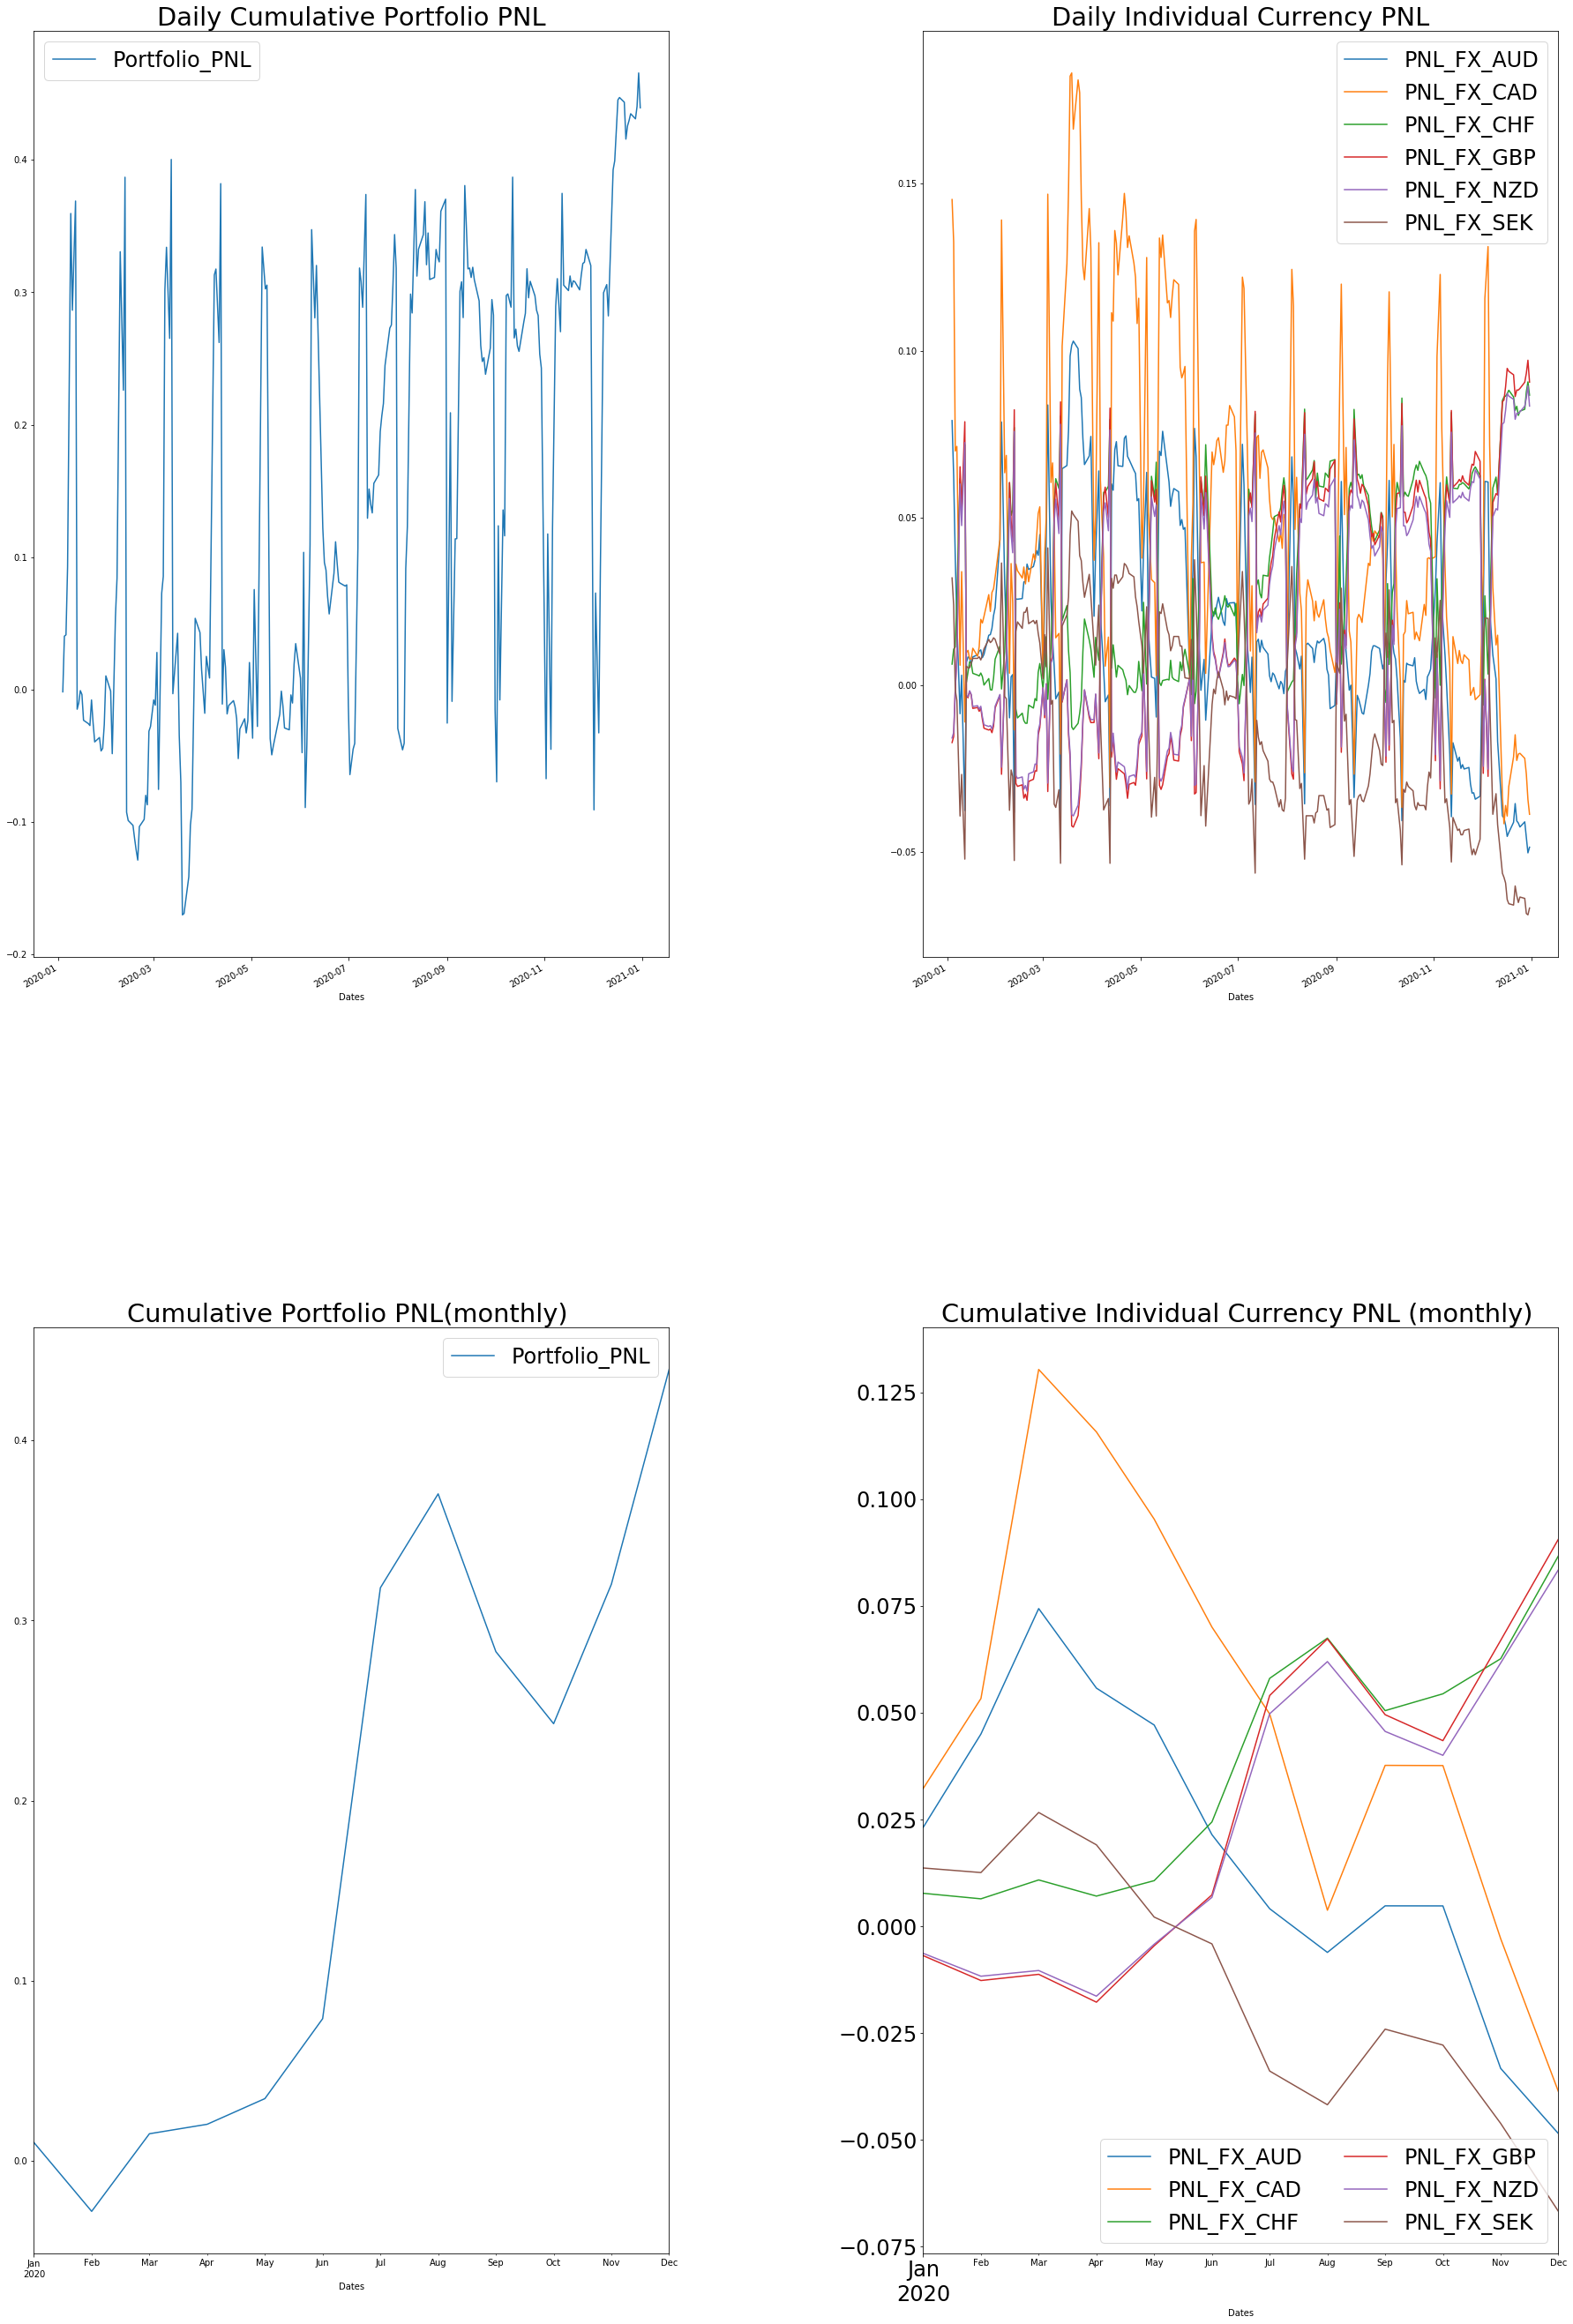

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,50))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=34)

cumulativePNL_mom_graph[["Portfolio_PNL"]].plot(title = "Daily Cumulative Portfolio PNL" ,ax=axes[0,0])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
cumulativePNL_mom_graph.iloc[:,:-1].plot(title = "Daily Individual Currency PNL",ax=axes[0,1])

plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)
plt.legend(loc='lower right', ncol=2)

cumulativePNL_mom_graph[["Portfolio_PNL"]].resample('M').last().plot(title = "Cumulative Portfolio PNL(monthly) " ,ax=axes[1,0])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=14)

cumulativePNL_mom_graph.iloc[:,:-1].resample('M').last().plot(title = "Cumulative Individual Currency PNL (monthly) ",ax=axes[1,1])
plt.rcParams.update({'font.size': 24})
plt.tick_params(labelsize=24)
plt.legend(loc='lower right', ncol=2)

# Strategy 4: Value Strategy -  Dollar Neutral

## 1. Import List of Libraries 

In [43]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

## Final Portfolio Optimization code 
from cvxpy import *
import cvxpy as cp

import pandas as pd
import numpy as np

from datetime import datetime, timedelta
#from yahoo_finance import Share
import random
import warnings

warnings.simplefilter(action="ignore")

## 4.1 Upload Files - FX Rates  - G10 Currencies 

In [44]:
fx_nominal_df = pd.read_csv("G10_FX_CLOSE.csv")
fx_nominal_df ["DATE"] = pd.to_datetime(fx_nominal_df["DATE"])
fx_nominal_df  =fx_nominal_df .set_index('DATE')
fx_nominal_df  = fx_nominal_df .iloc[:,-10:-1]
fx_nominal_df.index  = fx_nominal_df.index.sort_values(ascending=True)
fx_nominal_df.columns = fx_nominal_df.columns.str.strip()
fx_real_df  = fx_nominal_df.copy()

In [ ]:
#fx_nominal_df .columns = ['JPY','GBP','CAD','AUD', 'NZD', 'CHF', 'DKK', 'NOK','SEK']

## 4.2 Upload Files - PPP Rates  - G10 Countries  

In [45]:
ppp_df = pd.read_csv("PPP.csv")
ppp_df['Year']=pd.to_datetime(ppp_df["Year"], format='%Y')
ppp_df = ppp_df.set_index('Year')
ppp_df.index = ppp_df.index.year
ppp_df.head(2)
fx_df_nominal = fx_nominal_df.copy()
ppp_df.columns
ppp_df.index.unique()
ppp_df.index  = ppp_df.index.sort_values(ascending=True)
ppp_df.columns = ppp_df.columns.str.strip()

## 4.3 Convert Nominal FX rates into real interest rates --> Nominal / ppp

In [46]:
for i in fx_real_df.index.year.unique():
    for j in fx_real_df.columns:
        fx_real_df[j][fx_real_df.index.year == i]  \
        = (fx_real_df[j][fx_real_df.index.year == i])/(ppp_df[j][ppp_df.index == int(i-1)].values)

## 4.4 Function : Split Data & Generate Trading Signal  -  T-Stat

In [51]:
from sklearn.preprocessing import StandardScaler
def test_train_df(df_,test_start:int,test_end:int):
    
    # Data Split   -  Nominal Rates 
    
    df_train = df_[(df_.index.year <= test_start-1)]
    df_train.index = df_train.index.sort_values()
    
    df_test = df_[(df_.index.year >= test_start) & (df_.index.year <=test_end)]
    df_test.index = df_test.index.sort_values()

    # Data Split - Real  - Test Data
    #fx_real_df_train =   fx_real_df[(fx_real_df.index.year <= test_start-1)]
    #fx_real_df_test  = fx_real_df.iloc[(fx_real_df.index.year >= test_start) & (fx_real_df.index.year <= test_end)]
    
    return {"Train":df_train,"Test":df_test}

from sklearn.preprocessing import StandardScaler
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

In [ ]:
"""from sklearn.preprocessing import StandardScaler
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-sddtat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)"""

## 4.6 Function :  get list of undervalued and Overvalued currencies & Construct DataFrame 

In [52]:
def UnderValuedCurrencies(Curdata):
    return GetTradingSignal(Curdata).sort_values(ascending = True).head(3)

def OvervaluedCurrencies(Curdata):
    return GetTradingSignal(Curdata).sort_values(ascending = False).head(3)

def OverValued_Under_Valued_df(df):
    over_v = df[OvervaluedCurrencies(df).index.values]
    under_v = df[UnderValuedCurrencies(df).index.values]
    return pd.concat([over_v,under_v],axis =1,ignore_index = False)


## 4.8 Dollar Neutral Portfolio Creation 


Action / Currency / Variable 
    1. Buy : JPY->  w[0]
    2. BUy : AUD ->  w[1] 
    3. Buy : CAD ->  w[2] 
    4. Sell :GBP  -> w[3]
    5. Sell :NZD  -> w[4]
    6. Sell : CHF -> w[5] 

- Constraints 

    1. w[0],w[1],w[2] ->  Sell and   w[3],w[4],w[5] : Buy
    2. Sum of Long currencies wieght <=0.50
    3. Sum of Song currencies wieght <=0.50
    4. Weight of Short  currencies  w >= -0.5,w <= 0
    5. Weight of Long   currenciesw w >= 0,w <= 0.5
   

- Optimization: 
    * Maximize ( expected Retrun - Gamma * Risk)




## 4.9 Function : Weight Generation  : High Return Portolio ( Lowest Sharp Ratio )  & Portfolio _ PNL Caclulation 

In [53]:
def portfolioWeights(df_,test_start,test_end):
    exp_return = 0.4 

    ## Gather real Exchange rates 
    train_data_real_fx = test_train_df(df_,test_start,test_end)['Train']
    
    print("Read Exchange rates - Training Data for period end on {}  is {}\n".format (test_start,train_data_real_fx))
    
    ## Undervalued 
    list_undevalue = UnderValuedCurrencies(test_train_df(df_,test_start,test_end)['Train'])
    list_overvalue = OvervaluedCurrencies(test_train_df(df_,test_start,test_end)['Train'])
    
    print("\nOvervalue Currencies \n {}".format(list_undevalue.index.values))
    print("\nUndervalue Currencies \n {}".format(list_overvalue.index.values))
    

    over_v = train_data_real_fx[OvervaluedCurrencies(train_data_real_fx).index.values]
    under_v = train_data_real_fx[UnderValuedCurrencies(train_data_real_fx).index.values]
    
    overvalued_undervalued_data = pd.concat([over_v,under_v],axis =1,ignore_index = False)
    print("\nOvervalued_Undervalued_data : \n : {}".format(overvalued_undervalued_data.head(2)))
    
    ## Percentage Change
    df_return = overvalued_undervalued_data.pct_change().dropna()
    
    print("\nDaily return :\n {}".format(df_return.head(2)))

    ## Convariance 
    cov_mat = overvalued_undervalued_data.cov()
    
    print("\nCovariance matrix : \n {}".format(cov_mat.head(2)))
    Sigma = cov_mat.values # np.asarray(cov_mat.values)

    print("\nSigma:\n {}".format(Sigma))
    
    ## Varaible Creation 
    w = cp.Variable(len(overvalued_undervalued_data.columns))
    
    print("\nVariable creation:{} ".format(len(overvalued_undervalued_data.columns)))
    
    ## mu 
    mu = np.array([exp_return]*len(cov_mat)) # mu is the vector of expected returns.
    
    print ("\nMu calculation :  \n {}".format(mu))
    mu = mu.reshape(-1,1)

    ## Expected Return 
    expected_return = mu.T@w 


    num_stocks = len(cov_mat)
    gamma = Parameter(nonneg=True)
    gamma.value = 1

    ## Risk Calculation 
    risk = quad_form(w, Sigma)


    ## Constraints 
    opt_constraints = [w[0] >= -0.5,w[0] <= -0.1,\
                       w[1] >= -0.5,w[1] <= -0.1,\
                       w[2] >= -0.5,w[2] <= -0.1,\
                       w[3] >= 0,w[3] <= 0.5,\
                       w[4] >= 0,w[4] <= 0.5,\
                       w[5] >= 0,w[5] <= 0.5, \
                       sum([w[0],w[1],w[2]]) == -0.50,\
                       sum([w[3],w[4],w[5]]) == 0.50] 


    ## Maximize -> Maximize(expected_return - gamma*risk)
    prob = cp.Problem(cp.Maximize(expected_return - gamma*risk),constraints=opt_constraints)
    prob.solve(qcp=True)

    weights_value_df = pd.DataFrame([w[0].value,w[1].value,w[2].value,w[3].value,w[4].value,w[5].value],index = overvalued_undervalued_data.columns)

    weights_value_df = weights_value_df.rename(columns = {0 : "Weight"})

    return weights_value_df



def PNL(pnl_,total_cash,weight,commission):
    Total_Cash = 1
    Value_fx_Value_df_return = pd.DataFrame()
    Value_fx_Value_df_return = Value_fx_Value_df_return .iloc[0:0]
    
    ## Percentage change 
    Value_fx_Value_df_return = pnl_[weights_value_df.index].pct_change().dropna(axis =0)
    
    
    Value_fx_Value_df_return.index  = Value_fx_Value_df_return.index.sort_values(ascending = True)
    
    for i in weights_value_df.index:
        print("Currency : {} , Currency Weight {} ".format(i,weights_value_df.loc[i][0]*Total_Cash))
        Value_fx_Value_df_return["PNL_"+i] = Value_fx_Value_df_return[i].apply(lambda x : x * (weights_value_df.loc[i][0]*Total_Cash))

     
    print("Total Weight  : Long - Short : {}".format(weights_value_df.sum()))
    
    
    print("\n \n CUMMULATIVE PNL - ACROSS DIFFERENT YEARS")  
    print("------------------------------------------------")
    PNLPortfolio_= Value_fx_Value_df_return.loc[:, Value_fx_Value_df_return.columns.str.startswith('PNL')]
    PNLPortfolio_["PNL_Portfolio"] = PNLPortfolio_.sum(axis =1)
   
    for i in PNLPortfolio_.index.year.unique().sort_values(ascending = True):
        print("\nCummulative PNL - year {} : {} ".format( i,\
        PNLPortfolio_[["PNL_Portfolio"]][PNLPortfolio_["PNL_Portfolio"].index.year == i].resample('Y').last()))
   
    PNLPortfolio_.to_csv("portfolio_CumulativePNL.csv")

    return PNLPortfolio_

## 5.1 Function : Graph Plot  

In [54]:
def graph(df_):
    fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(30,30))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    print("\n\nGraphs")
    df_["PNL_Portfolio"].plot(title = "Daily Cumulative PNL - Portfolio  " ,ax=axes[0,0])
    plt.tick_params(labelsize=24)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
    
    df_.iloc[:,:-1].plot(title = "Daily Individual Currency PNL",ax=axes[0,1])
    plt.legend(loc='lower right', ncol=2)
    plt.tick_params(labelsize=84)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)

    
    df_["PNL_Portfolio"].resample('M').last().plot(title = "Monthly - Cumulative Portfolio PNL" ,ax=axes[1,0])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
   
    df_.iloc[:,:-1].resample('M').last().plot(title = "Monthly - Cumulative Individual Currency PNL",ax=axes[1,1])
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    
    
    df_["PNL_Portfolio"].resample('Y').last().plot(title = "Yearly - Cumulative Portfolio PNL" ,ax=axes[2,0])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
    
    
    df_.iloc[:,:-1].resample('Y').last().plot(title = "Yearly - Cumulative Individual Currency PNL",ax=axes[2,1])
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)
    

# 5.2 Execution  -  Execution Of Value Strategy 

In [55]:
def graph(df_):
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,30))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)


    df_["PNL_Portfolio"].plot(title = "Daily Cumulative PNL - Portfolio  " ,ax=axes[0,0])
    plt.tick_params(labelsize=24)
    
    df_.iloc[:,:-1].plot(title = "Daily Individual Currency PNL",ax=axes[0,1])
    plt.legend(loc='lower right', ncol=2)
    plt.tick_params(labelsize=84)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
    
    df_["PNL_Portfolio"].resample('M').last().plot(title = "Monthly - Cumulative Portfolio PNL" ,ax=axes[1,0])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=14)
   
    df_.iloc[:,:-1].resample('M').last().plot(title = "Monthly - Cumulative Individual Currency PNL",ax=axes[1,1])
    plt.legend(loc='lower right', ncol=2)
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(labelsize=24)

NameError: name 'weights_value_df' is not defined

## 4.9 Cumultive PNL 

In [ ]:
fx_df_nominal_test = test_train_df(fx_nominal_df,2014,2020)['Test'] 

def PNL(pnl_,total_cash,weight,commission):
    Total_Cash = 1
    Value_fx_Value_df_return = pd.DataFrame()
    Value_fx_Value_df_return = Value_fx_Value_df_return .iloc[0:0]
    
    ## Percentage change 
    Value_fx_Value_df_return = pnl_[weights_value_df.index].pct_change().dropna(axis =0)
    
    
    Value_fx_Value_df_return.index  = Value_fx_Value_df_return.index.sort_values(ascending = True)
    
    for i in weights_value_df.index:
        print("Currency : {} , Currency Weight {} ".format(i,weights_value_df.loc[i][0]*Total_Cash))
        Value_fx_Value_df_return["PNL_"+i] = Value_fx_Value_df_return[i].apply(lambda x : x * (weights_value_df.loc[i][0]*Total_Cash))

     #print("\nTotal Weight: {}".format(sum(weights_value_df.values)))
    print(weights_value_df.values[1])
    
    
    ## Cummulative PNL at portfolio level    
    PNLPortfolio_= Value_fx_Value_df_return.loc[:, Value_fx_Value_df_return.columns.str.startswith('PNL')]
    PNLPortfolio_["PNL_Portfolio"] = PNLPortfolio_.sum(axis =1)
   
    for i in PNLPortfolio_.index.year.unique().sort_values(ascending = True):
        print("\nPNL at end of year {}  : {} ".format(i,
        PNLPortfolio_[["PNL_Portfolio"]][PNLPortfolio_["PNL_Portfolio"].index.year == i]. \
            resample('Y').last().values[0]))

    
    PNLPortfolio_.to_csv("portfolio_CumulativePNL.csv")

    return PNLPortfolio_


fx_df_nominal_test = test_train_df(fx_nominal_df,2014,2020)['Test'] 
PNLPortfolio_ = PNL(fx_df_nominal_test,1,weights_value_df,0.000002)

graph(PNLPortfolio_)

In [ ]:
PNLPortfolio_["PNL_Portfolio"][PNLPortfolio_["PNL_Portfolio"].index.year == 2020].resample('Y').last()[0]

## 4.10 Graphs- Cumulative PNL 

In [ ]:
"""print(cumulative_value_PNL_df.head(2))
cumulative_value_PNL_df = cumulative_value_PNL_df[cumulative_value_PNL_df.columns[pd.Series(cumulative_value_PNL_df.columns).str.startswith('PNL')]\
                 |  \
                 cumulative_value_PNL_df.columns[pd.Series(cumulative_value_PNL_df.columns).str.startswith('Portfolio')]\
                ]
print(cumulative_value_PNL_df.head(2))"""

In [ ]:
cumulative_value_PNL["Portfolio_PNL"].resample('Y').last()[cumulative_value_PNL.resample('Y').last().index.year == \
cumulative_value_PNL.index.year.unique().max()]

In [ ]:
PNLPortfolio_[["PNL_Portfolio"]][PNLPortfolio_["PNL_Portfolio"].index.year == 2014].resample('Y').last().values[0]

## COMBINE

### Combined Strategies

In [ ]:
t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-s_rate   
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*s_rate*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*s_rate
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

'''
t_strategy_pnl_pct=(t_strategy_pnl+1).pct_change()
t_strategy_pnl_pct=t_strategy_pnl_pct.replace([np.inf, -np.inf], np.nan)
t_strategy_pnl_pct=t_strategy_pnl_pct.fillna(0)
'''

t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
plt.show()

In [ ]:
"""combine two strategies """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-s_rate   
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*s_rate*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*s_rate
value_pnl = value_pnl.sum(axis=1)


Combined_pnl = money_pnl + value_pnl
'''
Combined_pnl_pct=(Combined_pnl+1).pct_change()
Combined_pnl_pct=Combined_pnl_pct.replace([np.inf, -np.inf], np.nan)
Combined_pnl_pct=Combined_pnl_pct.fillna(0)
'''

Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

In [ ]:
plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')
plt.plot()
plt.legend()
plt.show()

In [ ]:
plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')


pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

### Combined Strategies Performance Results

In [ ]:
"""sharpe ratio""" 
print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("Pairs Trade return: %.4f, Pairs Trade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs))
print ("Carry Trade return: %.4f, Carry Trade sharpe ratio: %.4f" %(t_strategy_pnl[-1], cal_sharpe(history_sum,total_cf_allq,s))) 
print ("Combined Strategy return: %.4f, Combined Strategy sharpe ratio: %.4f" %(Combined_pnl[-1],Combined_pnl.mean()/Combined_pnl.std()))

In [ ]:
"""output position,pnl"""
#strategy_net_val = pd.concat([pairs_pnl,t_strategy_pnl,Combined_pnl],axis=1)
#strategy_net_val.columns = ['pair_trading','t_strategy','combined']
#strategy_net_val.to_csv("strategy_net_value.csv")
#combine_value_signal.to_csv("position_daily.csv")

In [ ]:
### Combined Strategies

t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-s_rate   
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*s_rate*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*s_rate
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

'''
t_strategy_pnl_pct=(t_strategy_pnl+1).pct_change()
t_strategy_pnl_pct=t_strategy_pnl_pct.replace([np.inf, -np.inf], np.nan)
t_strategy_pnl_pct=t_strategy_pnl_pct.fillna(0)
'''

t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
plt.show()

"""combine two strategies """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-s_rate   
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*s_rate*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*s_rate
value_pnl = value_pnl.sum(axis=1)


Combined_pnl = money_pnl + value_pnl
'''
Combined_pnl_pct=(Combined_pnl+1).pct_change()
Combined_pnl_pct=Combined_pnl_pct.replace([np.inf, -np.inf], np.nan)
Combined_pnl_pct=Combined_pnl_pct.fillna(0)
'''

Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')
plt.plot()
plt.legend()
plt.show()

plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,2)))
#plt.plot(pairs_pnl,label='pairs trade')
plt.plot(Combined_pnl,label = 'combined strategy    SR:'+str(round(Combined_pnl.mean()/Combined_pnl.std(),4)))
#plt.plot(Combined_pnl,label = 'combined strategy')


pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# polt the whole pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

### Combined Strategies Performance Results

"""sharpe ratio""" 
print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("Pairs Trade return: %.4f, Pairs Trade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs))
print ("Carry Trade return: %.4f, Carry Trade sharpe ratio: %.4f" %(t_strategy_pnl[-1], cal_sharpe(history_sum,total_cf_allq,s))) 
print ("Combined Strategy return: %.4f, Combined Strategy sharpe ratio: %.4f" %(Combined_pnl[-1],Combined_pnl.mean()/Combined_pnl.std()))

"""output position,pnl"""
#strategy_net_val = pd.concat([pairs_pnl,t_strategy_pnl,Combined_pnl],axis=1)
#strategy_net_val.columns = ['pair_trading','t_strategy','combined']
#strategy_net_val.to_csv("strategy_net_value.csv")
#combine_value_signal.to_csv("position_daily.csv")